In [1]:
import numpy as np
import pandas as pd
# load mat file
import scipy

In [122]:
df = pd.read_csv("datasets/restaurants/rating_final.csv")

# Create a bipartite graph and extract the biadjacency matrix
from networkx.algorithms import bipartite
import networkx as nx
import numpy as np

bottom_nodes = df.iloc[:, 0].unique()
top_nodes = df.iloc[:, 1].unique()

# generator = np.random.default_rng(0)
# bottom_nodes = generator.choice(bottom_nodes, 500, replace=False)
# top_nodes = generator.choice(top_nodes, 500, replace=False)

B = nx.Graph()
B.add_nodes_from(bottom_nodes, bipartite=0)
B.add_nodes_from(top_nodes, bipartite=1)

B.add_edges_from([(row.iloc[0], row.iloc[1]) for idx, row in df.iterrows()])

d = bipartite.biadjacency_matrix(B, bottom_nodes, top_nodes).todense().astype(np.float32)

In [175]:
mat = scipy.io.loadmat('datasets/irmdata/alyawarradata.mat')
d = mat['Rs']

In [176]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import sys
sys.path.append("/Users/aleix11alcacer/Projects/archetypes")

In [178]:
from archetypes.algorithms.torch import NAA, NAA2
from models import BiAA, DBiAA
import torch

In [180]:
data = torch.tensor(d).float().reshape(d.shape)


In [207]:
model = NAA2((16, 16), d.shape, relations=[0, 0], degree_correction=False, membership="hard", device="cpu", 
             loss="bernoulli")

model.fit(data, n_epochs=2_000, learning_rate=0.05)


torch.Size([16, 16, 26])


  0%|          | 0/2000 [00:00<?, ?it/s]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [104], [104, 16, 16]

In [190]:
model = BiAA((8, 8), data, assignment="hard", likelihood="bernoulli")

model.fit(2_000, learning_rate=0.01, threshold=0)

ValueError: too many values to unpack (expected 2)

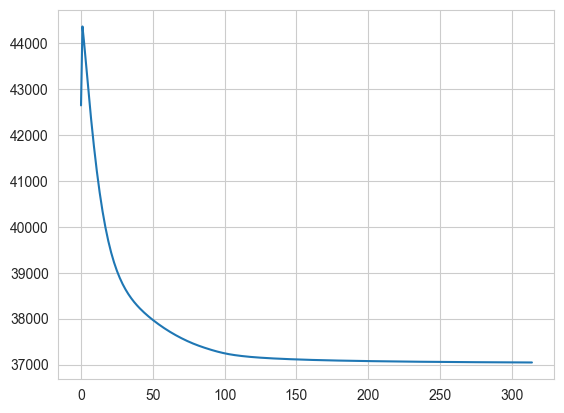

In [205]:
import matplotlib.pyplot as plt
plt.plot(model.losses)
plt.show()

In [192]:
from archetypes.visualization import heatmap
from archetypes.datasets import sort_by_archetype_similarity

/Users/aleix11alcacer/Projects/archetypes/archetypes/visualization/heatmap.py:113: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(
/Users/aleix11alcacer/Projects/archetypes/archetypes/visualization/heatmap.py:132: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(


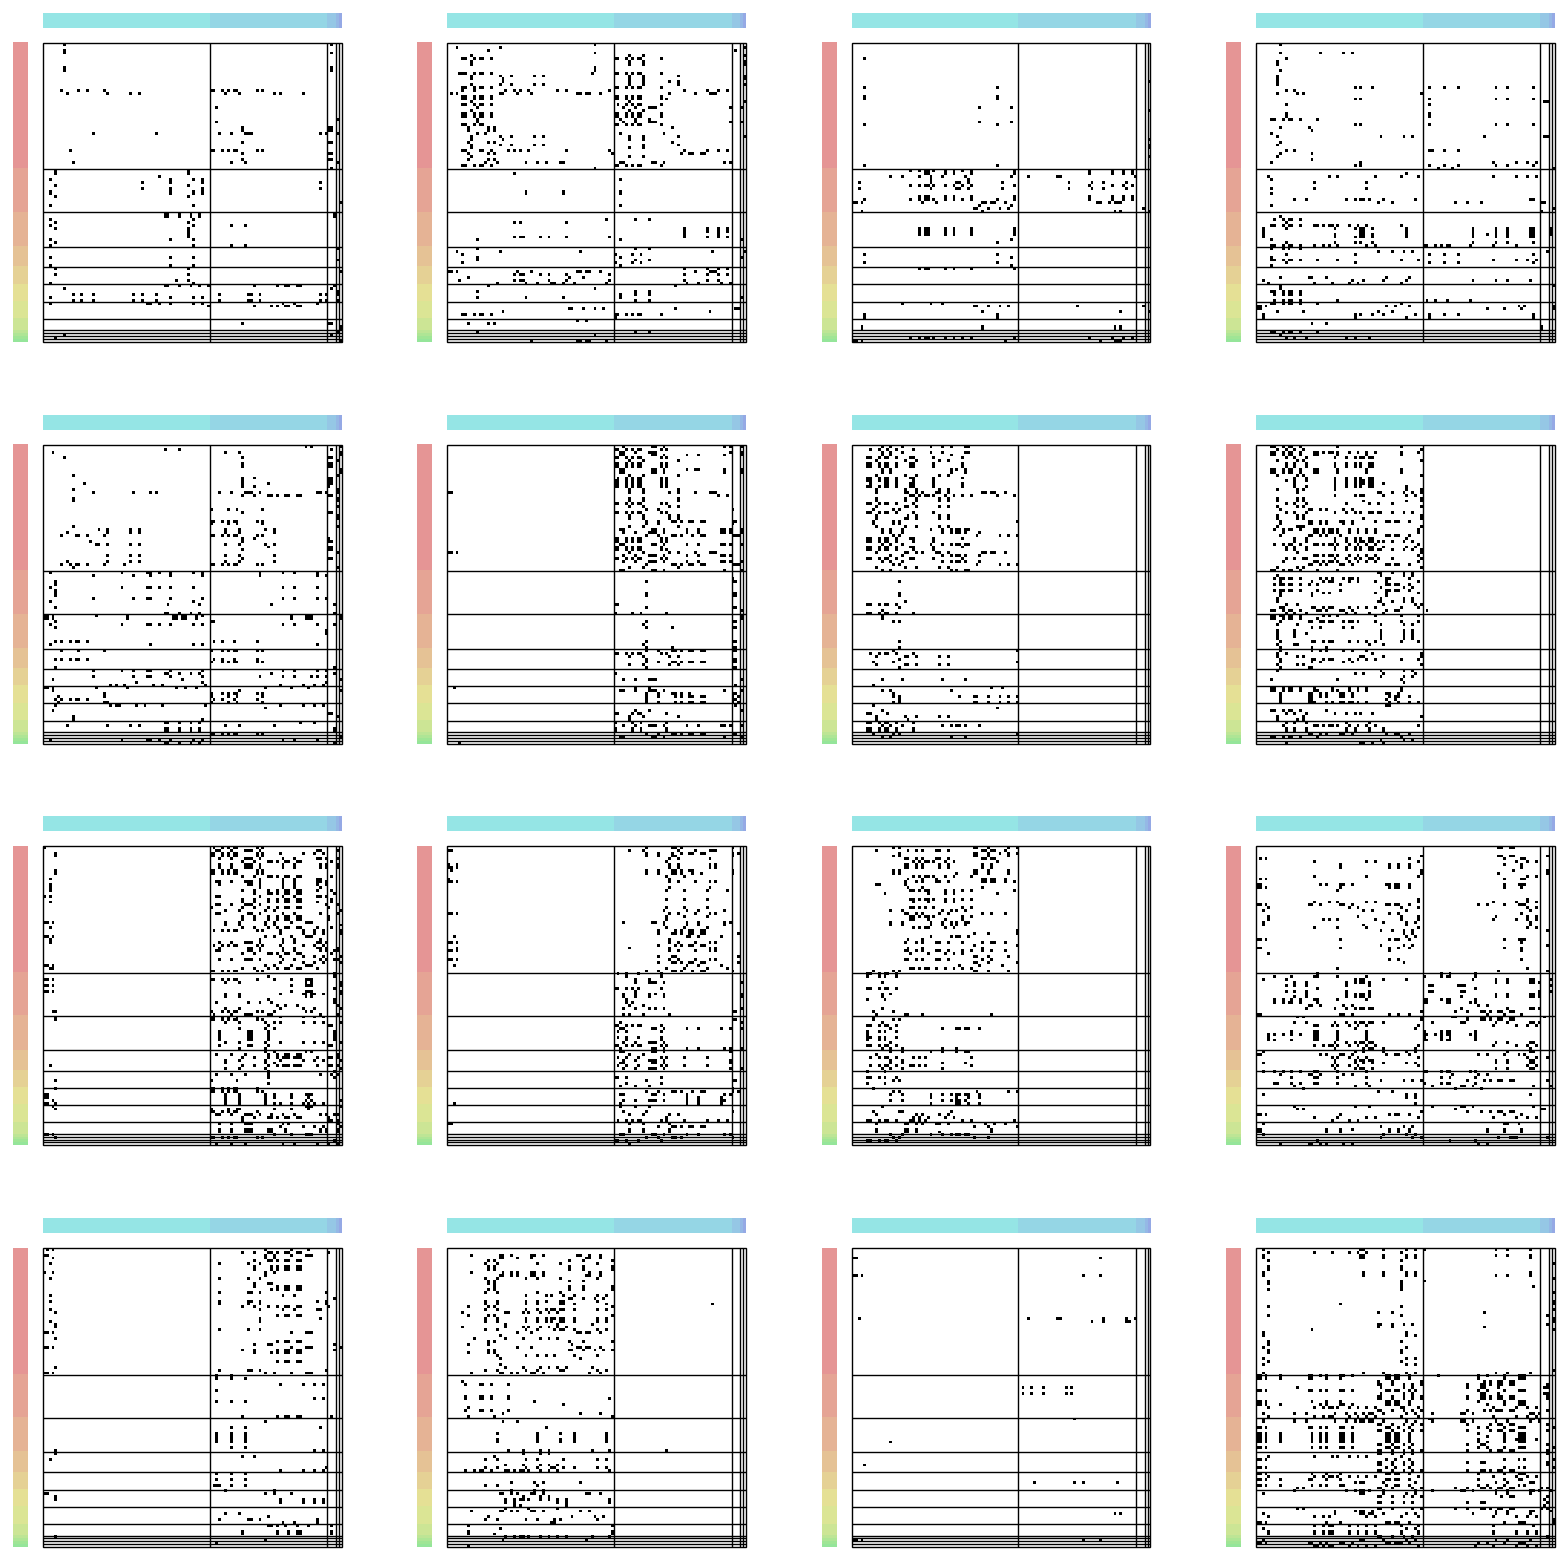

In [206]:
# alphas = [model.A.detach().numpy(), model.D.detach().numpy().T]
alphas = [a.detach().numpy() for a in model.A]
estimated_archetypes = model.Z.detach().numpy()

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    data_s, info_s = sort_by_archetype_similarity(data[:, :, i], alphas, estimated_archetypes)
    heatmap(data_s, info_s["labels"], info_s["n_archetypes"], info_s["scores"], ax=ax)

plt.show()